### Latent ideology of users

LI is based on the media outlet shared by each user, therefore the ideology reflects the group of media an user shares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(123459)

In [2]:
# Data with only columns of interest
data = pd.read_csv('Data/dataEchoChambers.csv', usecols=['tw_id', 'fecha', 'usr_id', 'opinion_dinamic', 'url_expanded', 'medio'])
data.head(n = 5)

,fecha,url_expanded,medio,opinion_dinamic,tw_id,usr_id
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346910135377920,716295311342321665
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346845589233665,271519704
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350580142903296,987494618156675072
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350441126936580,770375532
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101353444135370754,740350122974937088


### Encoding matrix user - media share
User - media shares dataframe based on one-hot encoding of media shares

In [3]:
user_media_df = pd.DataFrame()

# user_id column
user_media_df['usr_id'] = data['usr_id']

#creating instance of one-hot-encoder and one-hot encoding of media shares
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['medio']]).toarray())
encoder_df.columns = list(encoder.categories_[0])

user_media_df = user_media_df.join(encoder_df)

In [4]:
user_media_df = user_media_df.groupby('usr_id').sum()
user_media_df.head(n = 5)

,Ambito Financiero,Clarin,Contexto,Diario Registrado,El Cronista,El Destape,El Dia,El Litoral,Infobae,Jornada,La Izquierda Diario,La Nacion,Minuto Uno,Pagina 12,Perfil,Radio Dos,Radio Mitre,TYC Sports,Todo Noticias
usr_id,,,,,,,,,,,,,,,,,,,
12864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59173,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
624143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from scipy.stats import entropy

number_media_effective = user_media_df.apply(lambda x: 2**entropy(x, base = 2), axis = 1).to_list()

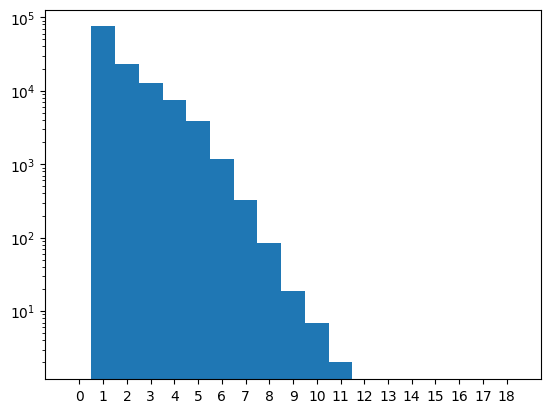

In [20]:
plt.hist(number_media_effective, bins = np.arange(-0.5, 19.5, 1))
plt.yscale('log')
plt.xticks(range(0, 19))
plt.show()

In [26]:
2**entropy([100, 30], base = 2)

1.7163572076839735

### Media share index

Correspondence analysis over the data of user - media share

In [5]:
# correspondence analysis function
def calculate_scores(A, it=15):
    P = (1/np.sum(A))*A #Nomalized natrix

    #Defining needings for standardizing
    n_col = np.shape(P)[1]
    n_row = np.shape(P)[0]
    r = np.matmul(P, np.ones((n_col,))) #rows
    c = np.matmul(np.ones((n_row,)), P) #columns
    r2 = r**(-0.5)
    c2 = c**(-0.5)
    Dr2 = np.diag(r2)
    Dc2 = np.diag(c2)
    r_t = np.array([r]).transpose()
    c_new = np.array([c])

    #Standardized residuals
    S = np.matmul(np.matmul(Dr2, P - np.matmul(r_t,c_new)),Dc2)
    #Truncated SVD
    #U, sig, Vt = randomized_svd(S, n_components=1, n_iter=it, random_state=None)

    #FULL SVD
    U, sig, Vt = np.linalg.svd(S, full_matrices=False)

    #scores
    X_dim1 = np.matmul(Dr2,U)[:,0] #scores matrix
    scores = (-1 + 2 * (X_dim1-np.min(X_dim1))/np.ptp(X_dim1)) #scaled
    return scores

#### Aplication over data

Preprocessing: we take the principal media outlets and those users that share at least two different principal media outlets

In [6]:
user_media_df_filtrado = user_media_df[['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']].copy()

In [7]:
potential_users_msi_defined = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 0].shape[0]
print(potential_users_msi_defined)

110343


In [8]:
user_media_df_filtrado = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 1].copy()

In [9]:
user_media_df_filtrado.head(n = 5)

,Clarin,La Nacion,Pagina 12,Todo Noticias,Infobae,El Destape
usr_id,,,,,,
58613,0.0,2.0,0.0,0.0,1.0,0.0
59173,1.0,1.0,1.0,0.0,0.0,0.0
760916,0.0,1.0,0.0,0.0,1.0,0.0
778189,3.0,2.0,0.0,0.0,0.0,0.0
794332,23.0,3.0,0.0,0.0,3.0,2.0


In [10]:
# Amount of users involved in MSI 
user_media_df_filtrado.shape[0]

42062

#### Aplication of correspondence analysis over the matrix: 

In [11]:
# Matrix of user - media shared
A = user_media_df_filtrado.to_numpy()

# Aplication of the algorithm
score_users = calculate_scores(A)

### Result

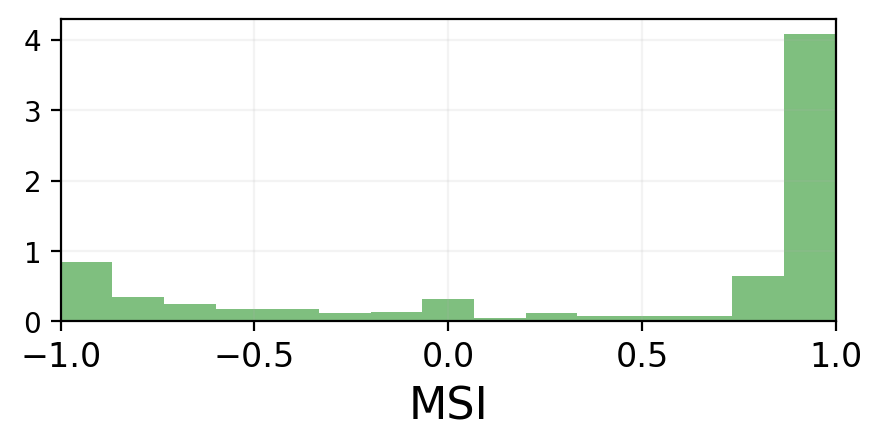

In [12]:
# Scores of the users
plt.figure(dpi = 200, figsize=(5,2))
plt.hist(score_users, bins = 15, range=(-1, 1), alpha = 0.50, color = 'g', density = True)
plt.xticks(np.arange(-1, 1.05, 0.50), size = 12)
plt.xlabel(r'MSI', size = 16)
plt.grid(True, alpha = 0.15)
plt.xlim([-1, 1])
plt.show()

In [13]:
user_media_df_filtrado['score'] = score_users

In [14]:
# Scores of the media
media_score = []
for media in user_media_df_filtrado.columns[:user_media_df_filtrado.shape[1]-1]:
    media_score.append([media, np.average(user_media_df_filtrado['score'], weights=user_media_df_filtrado[media])])

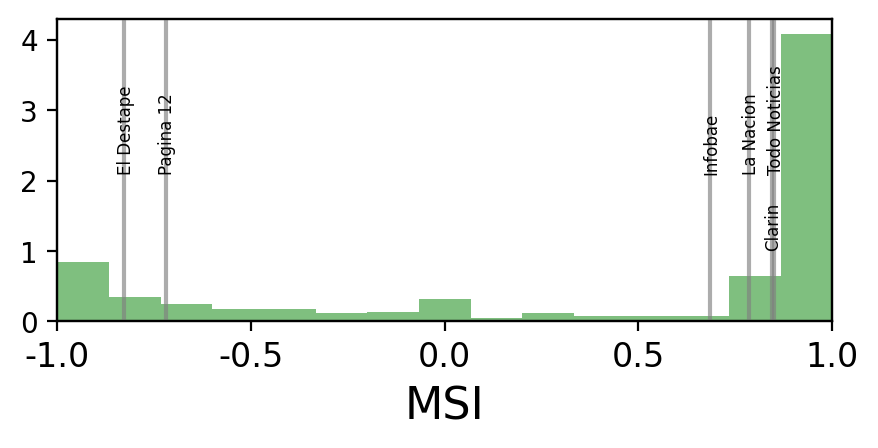

In [15]:
# Scores of the users
fig, ax = plt.subplots(dpi = 200, figsize=(5,2))
ax.hist(score_users, bins = 15, range=(-1, 1), alpha = 0.50, color = 'g', density = True)
ax.set_xlabel(r'MSI', size = 16)

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
ax.set_xticks(np.arange(-1, 1.05, 0.50), np.arange(-1, 1.05, 0.50), size = 12)
ax.set_xlim([-1, 1])
plt.show()

### Relation to opinion model 

The ideology of an user in the most frequent label assigned to it at the time of sharing a news.

In [16]:
from scipy.stats import mode 

In [17]:
user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])

In [18]:
ideology_of_msi_users = user_ideology[user_ideology.index.isin(user_media_df_filtrado.index)].to_list()

In [19]:
user_media_df_filtrado['ideology'] = ideology_of_msi_users

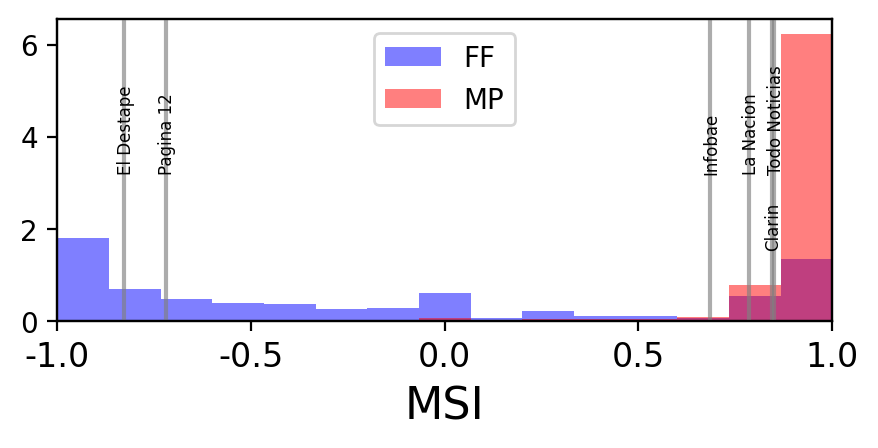

In [20]:
# Scores of the users
fig, ax = plt.subplots(dpi = 200, figsize=(5,2))

ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:
    ax.hist(user_media_df_filtrado[user_media_df_filtrado['ideology'] == ideology]['score'], bins = 15, range=(-1, 1), alpha = 0.50, color = ideocolor[ideology], density = True, label = ideology)
ax.set_xlabel(r'MSI', size = 16)
ax.legend(loc = 'upper center')

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
    
    
ax2.set_yticks([])
ax.set_xticks(np.arange(-1, 1.05, 0.50), np.arange(-1, 1.05, 0.50), size = 12)
ax.set_xlim([-1, 1])
plt.show()

### Other way 

In [21]:
score_users_new = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users_new = (score_users_new - np.mean(score_users_new))/np.std(score_users_new)

for iteration in range(25):
    
    score_media_new = np.array([np.average(score_users_new, weights=A[:,i]) for i in range(A.shape[1])])
    score_users_new = np.array([np.average(score_media_new, weights=A[j,:]) for j in range(A.shape[0])])

    score_users_new = (score_users_new - np.mean(score_users_new))/np.std(score_users_new)

In [22]:
score_users_new = (-1 + 2 * (score_users_new-np.min(score_users_new))/np.ptp(score_users_new)) #scaled

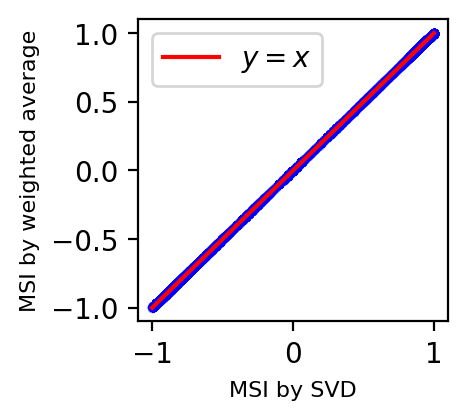

In [23]:
plt.figure(dpi = 200, figsize=(2,2))
plt.plot(score_users, score_users_new, marker = '.', alpha = 0.05, markersize = 5, color = 'b')
plt.plot([-1, 1], [-1, 1], label = r'$y = x$', color = 'r')
plt.legend(loc = 'best')
plt.xlabel('MSI by SVD', size = 8)
plt.ylabel('MSI by weighted average', size = 8)
plt.show()

In [24]:
score_media_new = np.array([np.average(score_users_new, weights=A[:,i]) for i in range(A.shape[1])])

Text(0.5, 1.0, "Media outlets' index")

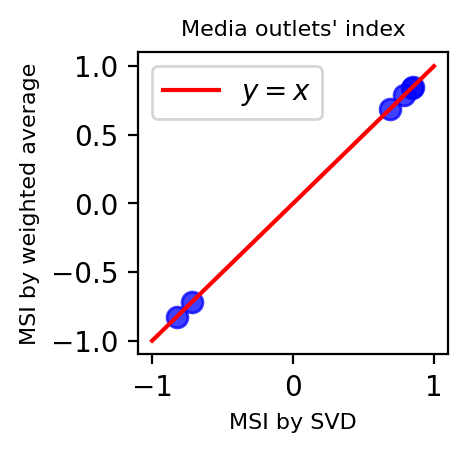

In [25]:
plt.figure(dpi = 200, figsize=(2,2))
plt.plot([m[1] for m in media_score], score_media_new, marker = '.', color = 'b', linewidth = 0, markersize = 15, alpha = 0.75)
plt.plot([-1, 1], [-1, 1], label = r'$y = x$', color = 'r')
plt.legend(loc = 'best')
plt.xlabel('MSI by SVD', size = 8)
plt.ylabel('MSI by weighted average', size = 8)
plt.title("Media outlets\' index", size = 8)

### Complete calculation 

In [26]:
#### Aplication over data
user_media_df_filtrado = user_media_df[['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']].copy()
user_media_df_filtrado = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 0].copy()

In [27]:
# Matrix of user - media shared
A = user_media_df_filtrado.to_numpy()

In [28]:
score_users_new = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users_new = (score_users_new - np.mean(score_users_new))/np.std(score_users_new)

for iteration in range(50):
    
    score_media_new = np.array([np.average(score_users_new, weights=A[:,i]) for i in range(A.shape[1])])
    score_users_new = np.array([np.average(score_media_new, weights=A[j,:]) for j in range(A.shape[0])])

    score_users_new = (score_users_new - np.mean(score_users_new))/np.std(score_users_new)
    
score_users = (-1 + 2 * (score_users_new-np.min(score_users_new))/np.ptp(score_users_new)) #scaled

In [29]:
score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
media_score = [[user_media_df_filtrado.columns[i], score_media[i]] for i in range(len(score_media))]
print(media_score)

[['Clarin', 0.8545083717377115], ['La Nacion', 0.8002235092774701], ['Pagina 12', -0.7447522505089922], ['Todo Noticias', 0.8712475816988725], ['Infobae', 0.6984512040494137], ['El Destape', -0.844023591837906]]


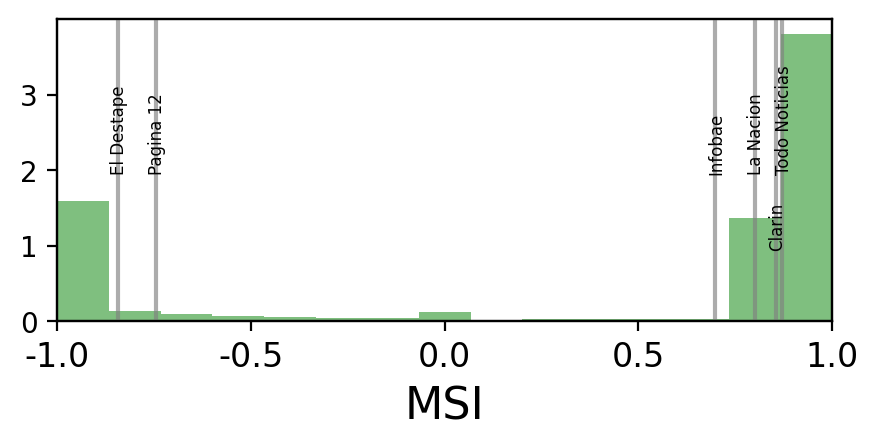

In [30]:
# Scores of the users
fig, ax = plt.subplots(dpi = 200, figsize=(5,2))
ax.hist(score_users, bins = 15, range=(-1, 1), alpha = 0.50, color = 'g', density = True)
ax.set_xlabel(r'MSI', size = 16)

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
ax.set_xticks(np.arange(-1, 1.05, 0.50), np.arange(-1, 1.05, 0.50), size = 12)
ax.set_xlim([-1, 1])
plt.show()

In [31]:
user_media_df_filtrado['score'] = score_users

In [32]:
user_ideology = data.groupby('usr_id').apply(lambda x: mode(x['opinion_dinamic'])[0][0])

ideology_of_msi_users = user_ideology[user_ideology.index.isin(user_media_df_filtrado.index)].to_list()

user_media_df_filtrado['ideology'] = ideology_of_msi_users

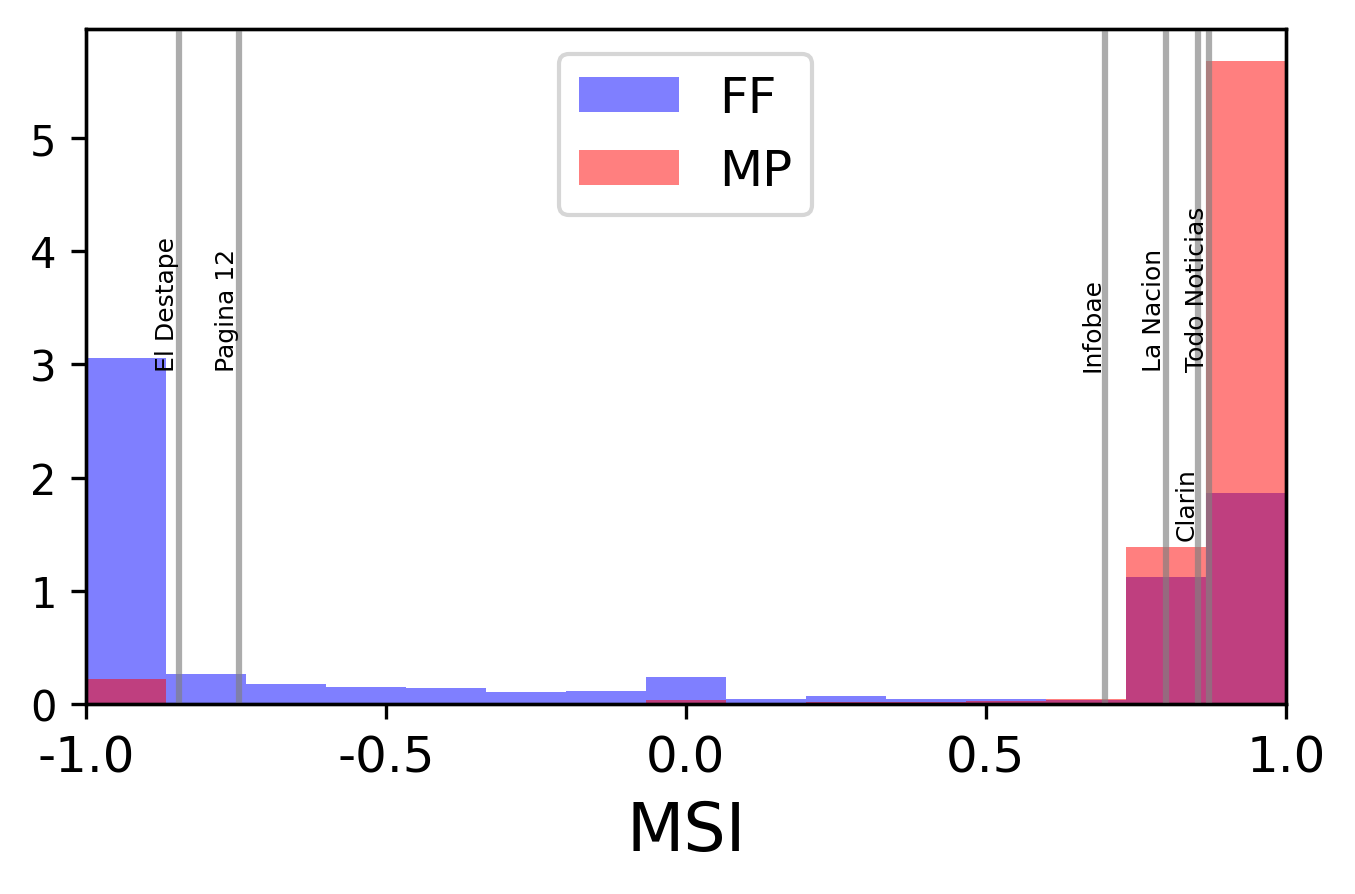

In [68]:
# Scores of the users
fig, ax = plt.subplots(dpi = 300, figsize=(5,3))
ax.set_position([0.10, 0.20, 0.80, 0.75])

ideocolor = {'FF': 'b', 'MP': 'r'}
for ideology in ['FF', 'MP']:
    ax.hist(user_media_df_filtrado[user_media_df_filtrado['ideology'] == ideology]['score'], bins = 15, range=(-1, 1), alpha = 0.50, color = ideocolor[ideology], density = True, label = ideology)
ax.set_xlabel(r'MSI', size = 16)
ax.legend(loc = 'upper center', fontsize = 12)

ax2 = ax.twinx()
ax2.set_position([0.10, 0.20, 0.80, 0.75])

for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.04, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.04, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
    
    
ax2.set_yticks([])
ax.set_xticks(np.arange(-1, 1.05, 0.50), np.arange(-1, 1.05, 0.50), size = 12)
ax.set_xlim([-1, 1])
plt.savefig('Results/MSI.png')
plt.show()

### Output

In [34]:
user_media_df_filtrado['score'].to_csv('Results/MSI_users_score_with_1outletshared.csv')